## Daniel Ruhman e Marcelo Prado - 2A

# Projeto 2 - Teste AB

### Introdução

O propósito desse projeto era realizar um teste AB para checar qual das versões era mais eficiente para determinada tarefa. O objeto de estudo foi o currículo elaborado por nós na disciplina de Co-Design de Aplicativos. Para determinar a eficiência da 

#### A Tarefa
  A tarefa escolhida pelo grupo foi encontrar o projeto "Estação Meterológica" e clicar nele. Uma vez que a versão A e a versão B eram muito diferentes uma da outra, queríamos testar qual versão era mais eficiente para ajudar o usuário a encontrar um projeto específico.
    
#### As Versões
**Versão A - Currículo do Daniel**

Nessa versão, os projetos encontram-se dentro de categorias, acessadas através de um menu seletor. Para encontrar um projeto específico, o usuário precisaria saber em qual categoria o projeto se encontra. 
<img src="demoA.png"> 

**Versão B - Currículo do Marcelo **

Nessa versão, os projetos encontram-se no final da página por imagens. Quando o usúario passa o mouse em cima do projeto, ele pode ver o nome e a disciplina. Nesse caso, o usuário precisaria rolar toda a página e procurar pelas imagens o projeto da estação.
<img src="demoB.png"> 


## Técnica Inferencial Usada

Para descobrir qual era o modelo estatístico mais adequado para analisar o teste AB, fizemos as seguintes considerações:

1. Estamos analisando duas amostras indendentes (versão A e B). Assim, temos duas variáveis aleatórias, X e Y
2. Não sabemos o desvio padrão das duas populações
3. Não sabemos se a variância de X e Y são iguais
4. As amostras podem possuir tamanhos distintos

O primeiro passo para decidir o modelo será verificar o tamanho e a variância de cada uma das amostras.

In [2]:
import pandas as pd
import json
import itertools
import matplotlib.pyplot as plt
import math

In [3]:
%matplotlib inline
arquivo = open("logs.json")
linhas = arquivo.readlines()
texto = "".join(linhas)
dados_fire = json.loads(texto)

In [4]:
# Preparação do JSON segundo referência do professor

lista_dicionarios = []

for k,v in dados_fire["logs"].items():
    lista_dicionarios.append(v)
    
dataframe = pd.DataFrame.from_records(lista_dicionarios)
agrupado = dataframe.groupby(by=["user_id", "versao"])
users = set(dataframe.user_id) # We convert it to a set so that each user appear only once
users = list(users) 

resultados = []

for u in users:
    for versao in ["A", "B"]:
        if (u, versao) in agrupado.groups.keys(): # Check if a specific pair user/type of test happened
            grupo1 =  agrupado.get_group((u, versao))
            grupo1 = grupo1.sort_values(by="tempo") # Para evitar que inícios sem fim gerem tempos negativos
            
            if len(grupo1[grupo1.tipo=="final"])>= 1 and len(grupo1[grupo1.tipo=="inicio"]) >= 1:
                delta_t = grupo1[grupo1.tipo=="final"].iloc[-1].tempo - grupo1[grupo1.tipo=="inicio"].iloc[0].tempo
                resultados.append({"user_id":u, "delta_t":delta_t, "versao":versao})
                

In [5]:
# Constrói a base de dados e remove valores absurdos
dataframe_resumo = pd.DataFrame.from_records(resultados)
dataframe_resumo.delta_t/=1000 # Convertendo milissegundos em segundos
dataframe_filtrado = dataframe_resumo[(dataframe_resumo.delta_t < 200)]

In [6]:
nA = dataframe_filtrado[(dataframe_filtrado.versao == "A")]
nB = dataframe_filtrado[(dataframe_filtrado.versao == "B")]
print("Tamanho de A: {0} \nTamanho de B: {1}".format(nA.versao.count(),nB.versao.count()))

Tamanho de A: 25 
Tamanho de B: 18


In [7]:
nA.describe()

,delta_t,user_id
count,25.000000,2.500000e+01
mean,42.312120,2.159660e+09
std,47.884906,1.284556e+09
min,4.571000,7.928211e+07
25%,13.528000,1.154931e+09
50%,24.355000,2.265674e+09
75%,42.536000,3.054759e+09
max,187.051000,4.158649e+09


In [8]:
nB.describe()

,delta_t,user_id
count,18.000000,1.800000e+01
mean,55.146222,1.979653e+09
std,44.487020,1.101035e+09
min,8.424000,6.897452e+08
25%,25.270250,1.238704e+09
50%,42.321500,1.630158e+09
75%,67.309500,2.834223e+09
max,164.399000,4.031768e+09


In [9]:
print("Variância de A e B")
print(nA.delta_t.var())
print(nB.delta_t.var())

Variância de A e B
2292.9642644433334
1979.0949305359477


Vamos agora plotar um Boxplot para ter uma ideia inicial da distribuição dos dados entre as diferentes versões:

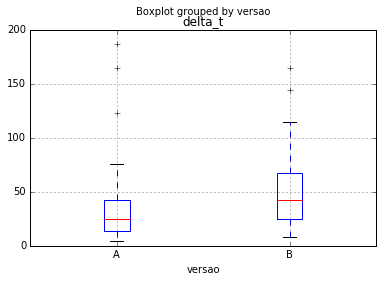

In [10]:
tempos_A = list(dataframe_filtrado[dataframe_filtrado.versao=="A"].delta_t)
tempos_B = list(dataframe_filtrado[dataframe_filtrado.versao=="B"].delta_t)

dataframe_filtrado.boxplot(column="delta_t",by="versao")

### Hipóteses

Analisando o Boxplot acima, podemos perceber que é possível que os usuários da versão A tenham encontrado o projeto com mais facilidade que os usuários da versão B. Dessa forma, definiremos as seguintes hipóteses:

hipótese alternativa (o que queremos descobrir): Média da versão A < Média da versão B. 
hipótese nula: Média da versão A = Média da versão B

H0 -> uA = uB

HA -> uA < uB

## Modelo a ser usado: amostras independentes com variâncias desconhecidas e diferentes


Como não sabemos os desvios padrões das duas populações, precisamos estimá-los através dos desvios padrões das amostras.

Como a varância da versão A é diferente da versão B, teremos de usar o modelo proposto na página 325 do Magalhães e Lima, o Caso 3B para Amostras Independentes com Variâncias desconhecidas e diferentes. Utilizaremos as seguintes fórmulas:

<img src="formulas.jpg">

In [12]:
# Versão A
mediaX = nA.delta_t.mean()
varX = nA.delta_t.var()
nX = nA.delta_t.count()

# Versão B
mediaY = nB.delta_t.mean()
varY = nB.delta_t.var()
nY = nB.delta_t.count()

d = mediaX - mediaY

varD = ((varX**2) / nX ) + ((varY**2) / nY)

t = d/(math.sqrt(varD))


grausLiberade = (varD ** 2)/ (((((varX**2)/nX)**2)/(nX-1)) + ((((varY**2)/nY)**2)/(nY-1)))

print("t: {0}\ngraus de liberdade: {1}".format(t,grausLiberade))

t: -0.019619598748128186
graus de liberdade: 39.563122645776694


### Região Crítica

**tObservado = -0.019619**

Definindo o nível de significancia (alpha) = 5%, e com 40 graus de liberdade, o T crítico será: **+-1.684** .
Observamos então que o tObservado não se encontra  na região crítica (-Tcrítico < tObservado < Tcrítico). Dessa forma, concluimos que a hipótese nula é válida com nível para o nível de significância de 5%.



## Conclusão

Como nosso tObservado não se encontra na região crítica, não rejeitamos H0. Dessa forma, através de uma análise estatística do teste AB, podemos concluir que os dois currículos não apresententam diferenças significativas no tempo necessário para encontrar um projeto.